In [ ]:
# !wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/ --directory-prefix "/content/drive/MyDrive/Colab Notebooks/ecg_data"

Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/ecg_data/physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2023-04-28 10:42:52 (341 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/ecg_data/physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2023-04-28 10:42:52--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/ecg_data/physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M   958KB/s    in 2.0s    

2023-04-28 10:42:54 (958 KB/s) - ‘/content/drive/MyDrive/Colab Notebooks/ecg_data/physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2023-04-28 10:42:54--  h

In [95]:
import pip
try:
    __import__("wfdb")
except ImportError:
    pip.main(['install', "wfdb"])   

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import pathlib
import glob
import scipy.signal as signal

from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import sklearn.metrics
import pandas as pd 

LOAD and READ DATA

In [96]:
data_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/ecg_data/physionet.org/files/mitdb/1.0.0")
patients = [pathlib.Path(p).name.replace(".hea", "") for p in glob.glob(str(data_path / "*.hea"))]
len(patients)

48

In [97]:
def data_dict(patients):

  patients_dict = {num_p: {} for num_p in range(len(patients)) }
  annotation_dict = {num_p: {} for num_p in range(len(patients)) }

  for i in range(len(patients)):

    patient = patients[i]
    annotation = wfdb.rdann(str(data_path / patient) , extension="atr")
    record = wfdb.rdrecord(data_path / patient )
    
    rec_keys = list(record.__dict__.keys())
    an_keys = list(annotation.__dict__.keys())

    for key in rec_keys:
      patients_dict[i][key] = record.__dict__.get(key)

    for key in an_keys:
      annotation_dict[i][key] = annotation.__dict__.get(key)

  return patients_dict, annotation_dict


In [98]:
pat, an = data_dict(patients)

In [8]:
for patient in patients:
  print( wfdb.rdrecord(data_path / patient ).comments)

['69 M 1085 1629 x1', 'Aldomet, Inderal']
['75 F 1011 654 x1', 'Diapres']
['84 F 1525 167 x1', 'Digoxin', 'The rhythm is paced with a demand pacemaker.  The PVCs are multiform.']
['66 F 1567 694 x1', 'Digoxin, Pronestyl', 'The rate of paced rhythm is close to that of the underlying sinus rhythm,', 'resulting in many pacemaker fusion beats.  The PVCs are multiform.  Several', 'bursts of muscle noise occur, but the signals are generally of good quality.']
['73 F 1624 1629 x1', 'Digoxin, Nitropaste, Pronestyl', 'The PVCs are uniform.  The predominant feature of this tape is', 'high-grade noise and artifact.']
['24 F 1581 654 x1', 'Inderal', 'The PVCs are multiform.']
['63 M 1340 167 x1', 'Digoxin', 'Complete heart block is present. The PVCs are multiform.']
['87 F 1227 654 x1', 'Digoxin, Quinaglute', 'There is borderline first degree AV block and sinus arrhythmia.  The', 'PVCs are multiform.  The lower channel exhibits considerable noise and', 'baseline shifts.']
['64 M 1508 694 x1', 'Qui

SIGNAL PROCESSING TECHNIQUES (filters)

In [6]:
def bandpass_filt(ecg, fs, f_low, f_high):
  """
  Apply bandpass filter to the ECG signal

  Input parameters: 
    ecg: The ECG signal
    f_low:  The low cutoff frequency
    f_high: The high cutoff frequency

  Output:
    The filtered ECG signal 

  """
    #   b, a = butter(2, [5, 15], btype='bandpass', fs=fs)
    # filtered_signal = filtfilt(b, a, ecg_signal)
  
  # Define filter parameters
  order = 1 # Filter order

  # Create bandpass filter
  b, a = signal.butter(order, [f_low , f_high ], btype='bandpass', fs =fs )

  filtered_ecg = signal.lfilter(b, a, ecg)        

  return filtered_ecg

In [7]:
def differentiation(ecg):
  """
  Find the derivative of the ECG signal 
  d(fy)
  """
  diff = np.diff(ecg)

  return diff 

In [8]:
def squaring(ecg):
  """
  Find the square of the ECG signal 
  (dy)^2
  """

  squared = ecg**2

  return squared 

In [9]:
def mwi(ecg, fs):
  """
  Apply moving-window integration to the given ECG signal
  """
  max_time = 0.083
  window_size = int(max_time * fs)
  ones = np.ones(window_size)
  
  # integrated_signal = np.convolve(squared_signal, ones, mode='valid')
  ecg_mwi = np.convolve(ecg, ones, mode='valid')

  return ecg_mwi

In [10]:
def r_peak_detection(ecg_detection, fs):    

    min_distance = int(0.15*fs)

    signal_peaks = [0]
    noise_peaks = []

    SPKI = 0.0
    NPKI = 0.0

    threshold_I1 = 0.0
    threshold_I2 = 0.0

    RR_missed = 0
    index = 0
    indexes = []

    missed_peaks = []
    peaks = []

    for i in range(1,len(ecg_detection)-1):
        if ecg_detection[i-1]<ecg_detection[i] and ecg_detection[i+1]<ecg_detection[i]:
            peak = i
            peaks.append(i)

            if ecg_detection[peak]>threshold_I1 and (peak-signal_peaks[-1])>0.2*fs:
                    
                signal_peaks.append(peak)
                indexes.append(index)
                SPKI = 0.125*ecg_detection[signal_peaks[-1]] + 0.875*SPKI
                if RR_missed!=0:
                    if signal_peaks[-1]-signal_peaks[-2]>RR_missed:
                        missed_section_peaks = peaks[indexes[-2]+1:indexes[-1]]
                        missed_section_peaks2 = []
                        for missed_peak in missed_section_peaks:
                            if missed_peak-signal_peaks[-2]>min_distance and signal_peaks[-1]-missed_peak>min_distance and ecg_detection[missed_peak]>threshold_I2:
                                missed_section_peaks2.append(missed_peak)

                        if len(missed_section_peaks2)>0:
                            signal_missed = [ecg_detection[i] for i in missed_section_peaks2]
                            index_max = np.argmax(signal_missed)
                            missed_peak = missed_section_peaks2[index_max]
                            missed_peaks.append(missed_peak)
                            signal_peaks.append(signal_peaks[-1])
                            signal_peaks[-2] = missed_peak   

            else:
                noise_peaks.append(peak)
                NPKI = 0.125*ecg_detection[noise_peaks[-1]] + 0.875*NPKI

            threshold_I1 = NPKI + 0.25*(SPKI-NPKI)
            threshold_I2 = 0.5*threshold_I1

            if len(signal_peaks)>8:
                RR = np.diff(signal_peaks[-9:])
                RR_ave = int(np.mean(RR))
                RR_missed = int(1.66*RR_ave)

            index = index+1      
    
    signal_peaks.pop(0)

    return signal_peaks

In [11]:
def Pan_Tompkins(ecg, fs, f_low, f_high):
  """

  """
  
  filtered_ecg = bandpass_filt(ecg, fs, f_low, f_high)
  dif_ecg = differentiation(filtered_ecg)
  square_ecg = squaring(dif_ecg)
  mwi_ecg = mwi(square_ecg, fs)

  r_peaks = r_peak_detection(mwi_ecg, fs)

  return mwi_ecg , r_peaks

EXTRACT R-PEAKS

In [13]:
def rpeaks_extr(pat, an, low, high):


  rpeaks_dict = {i:[] for i in pat}
  rpeaks_signal_dict = {i:[] for i in pat}
  fpfn_R_an_dict = {i:{'tp':[], 'fp':[], 'fn':[]} for i in pat}
  fpfn_R_R_dict = {i:{'tp':[], 'fp':[], 'fn':[]} for i in pat}

  for i in range(len(pat)) :

    ecg_1 = pat[i].get('p_signal')[:,0]
    fs = pat[i].get('fs')
    ecg_filt_1 , rpeaks_1 = Pan_Tompkins(ecg_1,fs, low, high)
    
    rpeaks_dict[i].append(rpeaks_1)

    
    peaks_1 = find_peaks(ecg_filt_1, distance=150)[0]

    # Calculate false positives and false negatives
    tp = 0
    fp = 0
    fn = 0

    length_an = len(an[i].get('sample'))

    for j in range(length_an):
        if an[i].get('sample')[j] in rpeaks_1:
            tp += 1
        elif np.any(np.logical_and(rpeaks_1 > an[i].get('sample')[j] - int(0.083*fs) , rpeaks_1 < an[i].get('sample')[j]+ int(0.083*fs))):
            fp += 1
        else:
            fn += 1

    fpfn_R_an_dict[i]['tp'].append(tp)
    fpfn_R_an_dict[i]['fp'].append(fp)
    fpfn_R_an_dict[i]['fn'].append(fn)

    # Calculate false positives and false negatives
    tp = 0
    fp = 0
    fn = 0

    length_an = len(peaks_1)

    for j in range(length_an):
        if peaks_1[j] in rpeaks_1:
            tp += 1
        elif np.any(np.logical_and(rpeaks_1 >peaks_1[j] - int(0.083*fs) , rpeaks_1 < peaks_1[j]+ int(0.083*fs))):
            fp += 1
        else:
            fn += 1

    fpfn_R_R_dict[i]['tp'].append(tp)
    fpfn_R_R_dict[i]['fp'].append(fp)
    fpfn_R_R_dict[i]['fn'].append(fn)
  
  
  return rpeaks_dict, fpfn_R_an_dict, fpfn_R_R_dict

In [12]:
i = 0
ecg = pat[i].get('p_signal')[:,0]
fs = pat[i].get('fs')
mwi_ecg , r_peaks = Pan_Tompkins(ecg, fs, 5, 12)
# filtered_ecg = bandpass_filt(ecg, fs, 5, 12)
# dif_ecg = differentiation(filtered_ecg)
# square_ecg = squaring(dif_ecg)
# mwi_ecg = mwi(square_ecg, fs)

# r_peaks = r_peak_detection(mwi_ecg, fs)

In [17]:
x = np.linspace(0, 1800, num=650000, endpoint=True)

In [108]:
sklearn.metrics.mean_squared_error(an[0].get('sample')[2:-1],r_peaks )

261.9881109643329

In [38]:
mwi_ecg[ an[0].get('sample')[0:20]]

array([0.00057139, 0.10127459, 0.14718148, 0.14550877, 0.13481201,
       0.10632051, 0.11549797, 0.13803445, 0.12790176, 0.15032504,
       0.12868209, 0.11639621, 0.11698904, 0.10264751, 0.13788613,
       0.13109661, 0.10544931, 0.13088226, 0.13003572, 0.10982593])

[Text(0, 0.5, 'MWI ECG')]

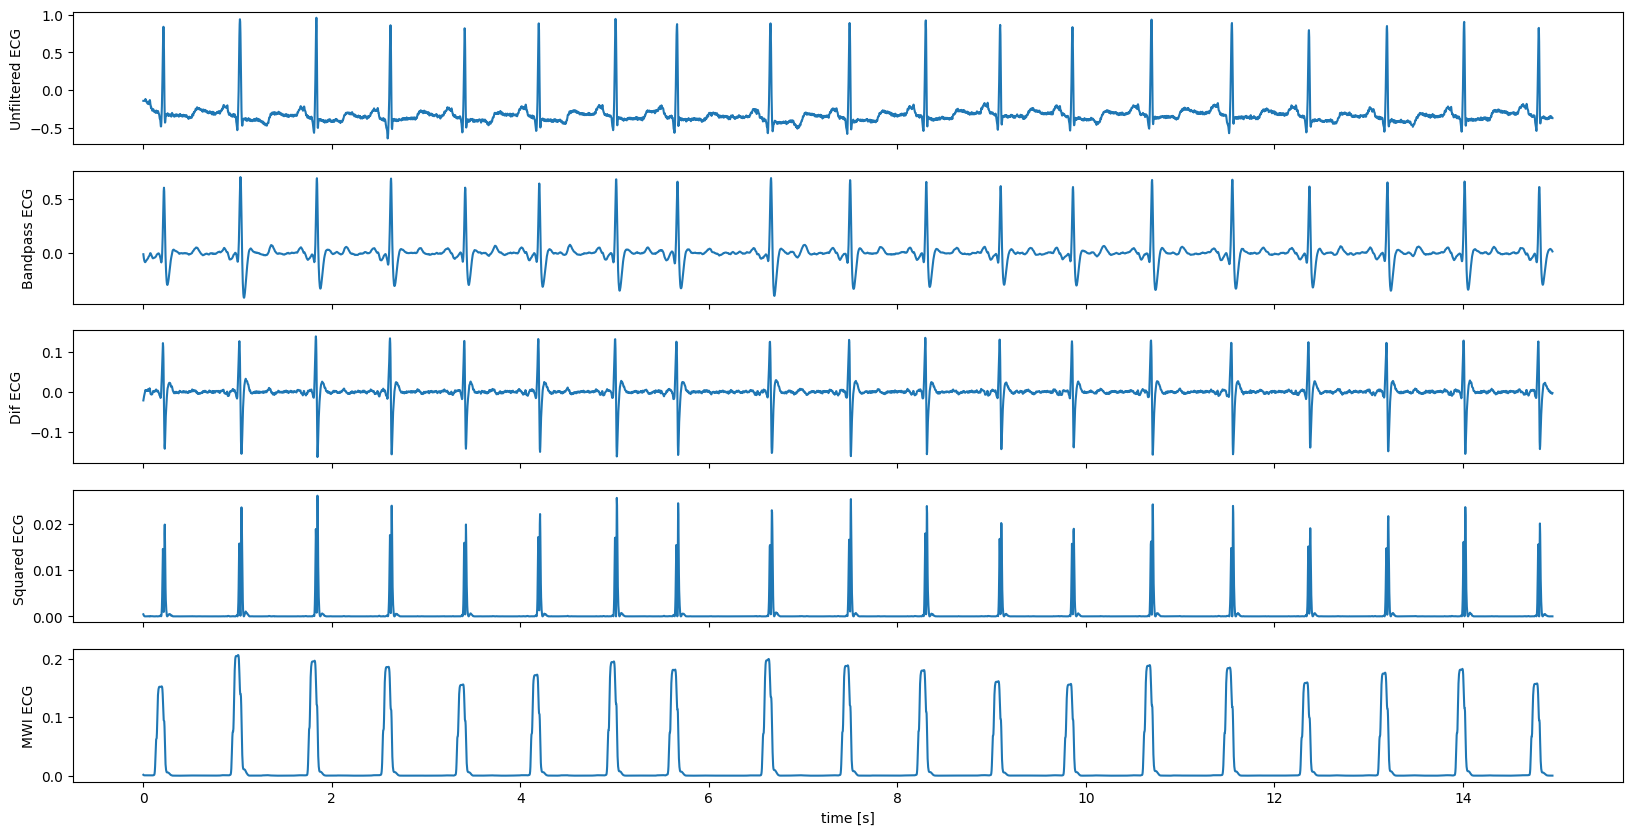

In [343]:
fig, axs = plt.subplots(5, 1, figsize= (20,10), sharex = True)
axs[0].plot(x[:5400],ecg[:5400])
axs[1].plot(x[:5400],filtered_ecg[:5400])
axs[2].plot(x[:5400],dif_ecg[:5400])
axs[3].plot(x[:5400],square_ecg[:5400])
axs[4].plot(x[:5400],mwi_ecg[:5400])
axs[4].set_xlabel('time [s]')
axs[0].set( ylabel='Unfiltered ECG')
axs[1].set( ylabel='Bandpass ECG')
axs[2].set( ylabel='Dif ECG')
axs[3].set( ylabel='Squared ECG ')
axs[4].set( ylabel='MWI ECG')


Text(0, 0.5, 'MWI ECG')

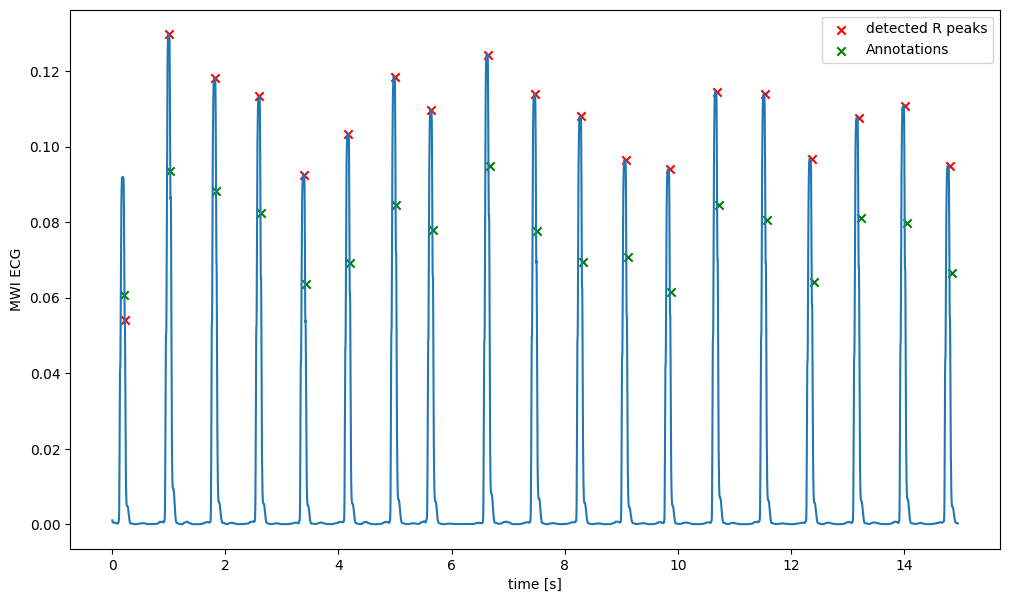

In [107]:
xx = [rp/360 for rp in r_peaks[:19]]
xx2 = [rp/360 for rp in an[0].get('sample')[1:20]]

yy= mwi_ecg[r_peaks[:19]] 
yy2= mwi_ecg[ an[0].get('sample')[1:20]]
fig, axs = plt.subplots(1, 1, figsize= (12,7), sharex = True)
axs.plot(x[:5400],mwi_ecg[:5400])
axs.scatter( xx, yy, c="r", marker='x',label = 'detected R peaks' )
axs.scatter( xx2, yy2, c="g", marker='x',label = 'Annotations' )
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('MWI ECG')
# axs[1].set( ylabel='Bandpass ECG')
# axs[2].set( ylabel='Dif ECG')
# axs[3].set( ylabel='Squared ECG ')
# axs[4].set( ylabel='MWI ECG')


In [28]:
def avg_fpfn(fpfn):
  avg_dict = {'tp':[], 'fp':[], 'fn':[]}

  for i in range(len(pat)):

    total = np.sum(list(fpfn[i].values()))
    for j in ['tp', 'fp', 'fn']:
      avg_val = (fpfn[i][j][0])/total 
      avg_dict[j].append(avg_val)

  return avg_dict

In [15]:
def calculate_heart_rate(peaks, sampling_rate):
  """
  Calculate heart rate from R-R intervals in seconds.

  Args:
  rr_intervals (list of floats): list of R-R intervals in seconds
  sampling_rate (float): sampling rate used to acquire ECG signal (in Hz)

  Returns:
  float: the average heart rate in beats per minute
  """

  period = 1/sampling_rate
  rs = [peaks[i]*period*1000 for i in range(len(peaks))]
  nn_intervals = np.diff(rs)
  hr = 60000/nn_intervals



  # # Convert R-R intervals to milliseconds
  # rr_intervals_ms = [interval * 1000 for interval in rr_intervals]

  # # Calculate heart rate in beats per minute
  # heart_rate = 60 * (len(rr_intervals) / sum(rr_intervals_ms) * 1000 / sampling_rate)

  return hr


In [16]:
def mean_heart_rate(r_p_dict, sampling_rate):

  means = np.zeros(len(r_p_dict))
  for i in range(len(r_p_dict)):

    hr = calculate_heart_rate(r_p_dict[i][0], sampling_rate)
    hr_avg = np.mean(hr)

    means[i] = hr_avg

  return means

In [17]:
def mm():
  means =[]
  sampling_rate = 360
  for i in range(len(an)):
    
    hr = calculate_heart_rate(an[i].get('sample'), sampling_rate)
    mean_hr = np.mean(hr)

    means.append(mean_hr)

In [309]:
hr_m1 = mean_heart_rate(rpeaks_dict, 360)

Text(0, 0.5, 'Mean heart rate')

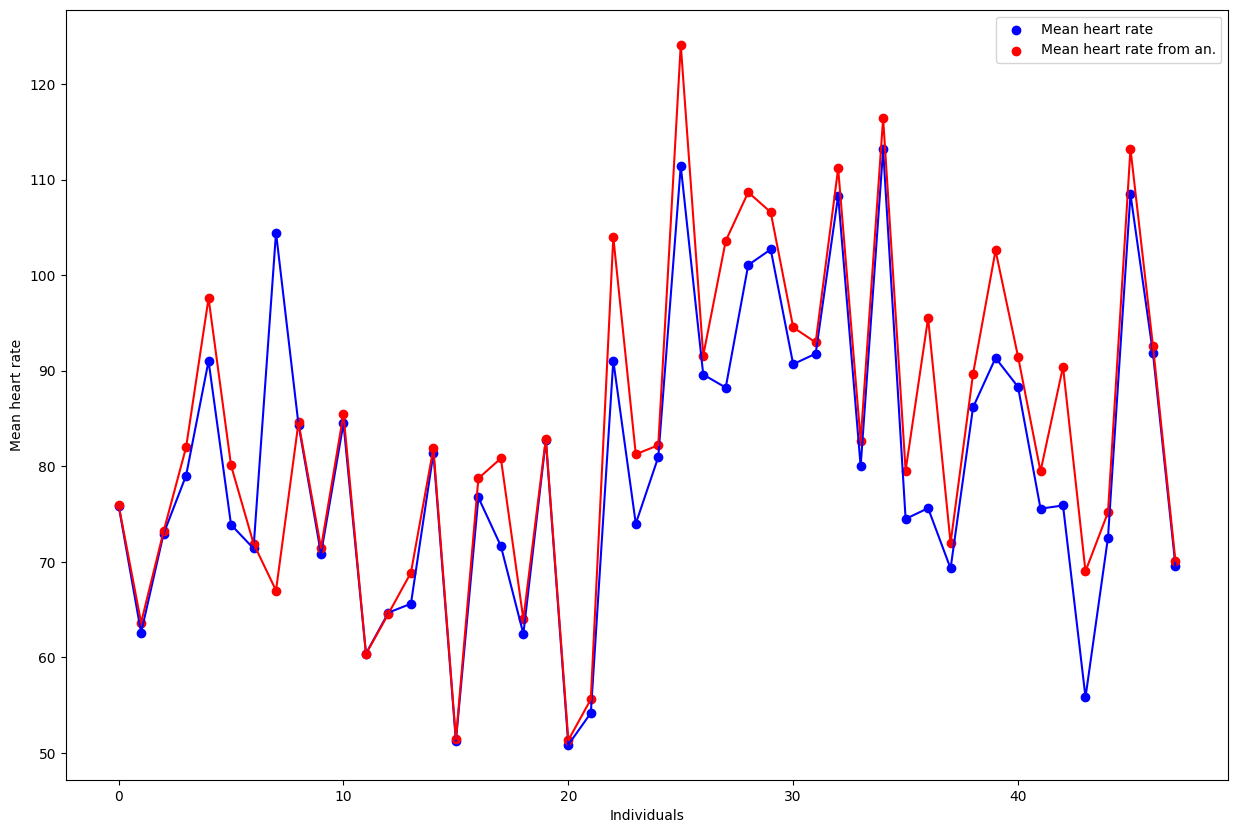

In [322]:
fig, axs = plt.subplots(1, 1, figsize = (15,10))
axs.plot([i for i in range(len(pat))],hr_m, color = 'b')
axs.plot([i for i in range(len(pat))],means, color = 'r')
axs.scatter([i for i in range(len(pat))],hr_m,color = 'b',label = 'Mean heart rate')
axs.scatter([i for i in range(len(pat))],means,color = 'r',  label = 'Mean heart rate from an.')
plt.legend()
plt.xlabel('Individuals')
plt.ylabel('Mean heart rate')

In [133]:
an_peaks = an[0].get('sample')
nn2 = nn_intervals(an_peaks)
hr2 = calculate_heart_rate(an_peaks,360)
hr2

array([366.10169492,  73.72013652,  73.97260274, ...,  85.71428571,
        86.4       ,  84.04669261])

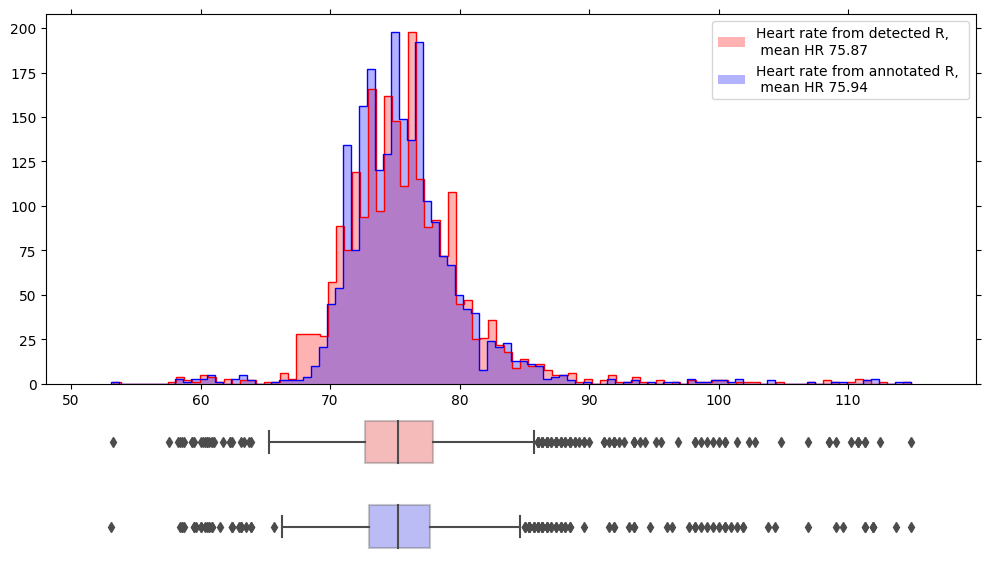

In [189]:
from scipy.stats import norm
import seaborn as sns
fig, axs = plt.subplots(3, 1, sharex = True ,figsize = (12,7), gridspec_kw={'height_ratios': [7, 1,1]})

min_val = min(min(hr1), min(hr2))-5
max_val = max(max(hr1), max(hr2[1:]))+5
# bins = np.linspace(min_val, max_val, num=150)

mu1, std1 = norm.fit(hr1)
mu2, std2 = norm.fit(hr2)

axs[0].hist(hr1, bins=100, histtype=u'step', color = 'r')
axs[0].hist(hr1, bins=100, alpha=0.3, label = 'Heart rate from detected R, \n mean HR %.2f' %mu1, color = 'r')
axs[0].hist(hr2[1:], bins=100, histtype=u'step', color = 'blue')
axs[0].hist(hr2[1:], bins=100, alpha=0.3, label = 'Heart rate from annotated R, \n mean HR %.2f' %mu2, color = 'blue')
sns.boxplot(hr1, ax = axs[1],color = 'r', boxprops=dict(alpha=.3), orient="h")
sns.boxplot(hr2[1:], ax = axs[2],color = 'blue', boxprops=dict(alpha=.3), orient="h")

axs[1].axis('off')
axs[2].axis('off')

axs[0].tick_params(reset=True)
plt.xlim(min_val, max_val)
axs[0].legend()

In [18]:
def healthy_not(an, percentage ):

      
  # Create a list of indices corresponding to healthy individuals
  healthy_idx = [i for i in range(len(an)) if (an[i].get('symbol').count('N')) >= percentage * len(an[i].get('symbol'))]

  # Create a list of indices corresponding to unhealthy individuals
  unhealthy_idx = [i for i in range(len(an)) if i not in healthy_idx]


  return healthy_idx, unhealthy_idx

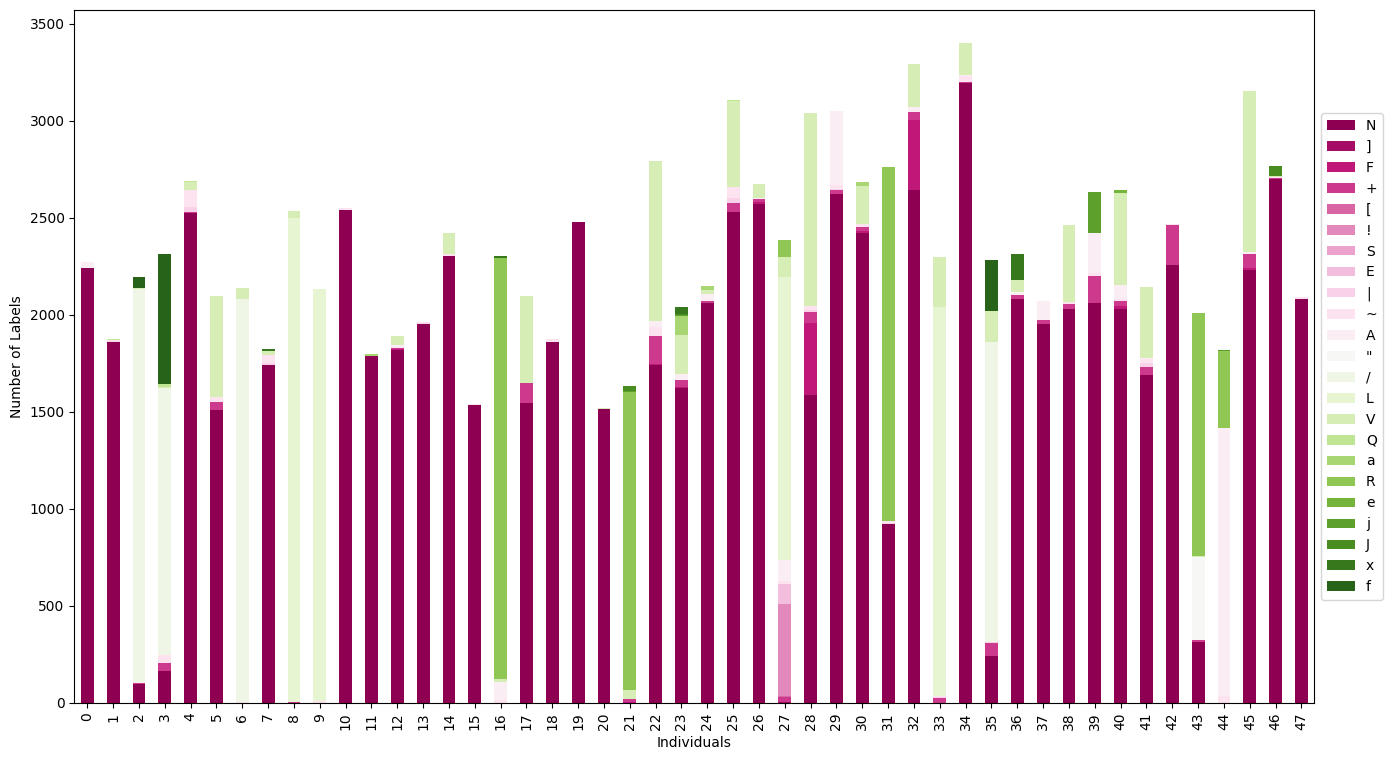

In [288]:

# create sample data with labels
data = test_dict
df = pd.DataFrame(data, index=[i for i in range(48)])

# create stacked bar plot
ax = df.plot(kind='bar', stacked=True, figsize=(16,9), cmap = 'PiYG')

# add labels and legend
ax.set_xlabel('Individuals')
ax.set_ylabel('Number of Labels')
ax.legend(title='Labels')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# show plot
plt.show()

In [227]:
symbols = {'!',  '"',  '+',  '/',  'A',  'E',  'F',  'J',  'L',  'N',  'Q',  'R',  'S',  'V',  '[',  ']',  'a',  'e',  'f',  'j',  'x',  '|',  '~'}
ftest ={ patient : list(np.zeros(len(symbols))) for patient in range(len(an))}

sym_list = list(symbols)
for p in range(len(an)):

  beat_sym = an[p].get('symbol')
  set_ = set(beat_sym)
  total_beats = len(beat_sym)

  for i in range(len(sym_list)):

    symbol = sym_list[i]
    count_ = beat_sym.count(symbol)

    ftest[p][i] = count_/total_beats 
    

In [ ]:
def count_beats(pat, an, num = True ):
  symbols = {'!',  '"',  '+',  '/',  'A',  'E',  'F',  'J',  'L',  'N',  'Q',  'R',  'S',  'V',  '[',  ']',  'a',  'e',  'f',  'j',  'x',  '|',  '~'}
  beats_dict ={ s_ : list(np.zeros(len(pat))) for s_ in symbols}
  list_set = list(symbols)

  for i in range(len(list_set)): 
    
    ss = list_set[i]
    
    for p in range(len(an)):
      
      AA = an[p].get('symbol')
      total_beats = len(AA)
      count_ = AA.count(ss)
      
      if num == True:
        beats_dict[ss][p] = count_ 
      else:
        beats_dict[ss][p] = count_ / total_beats

  return beats_dict
    

In [287]:
test_dict = count_beats(pat, an, num = True)

In [239]:
index = list(symbols)
A = []
for s_ in list(symbols):

  A.append(test_dict[s_])

df = pd.DataFrame({index[s_]: A[s_] for s_ in range(len(index))})


<Figure size 1500x1000 with 0 Axes>

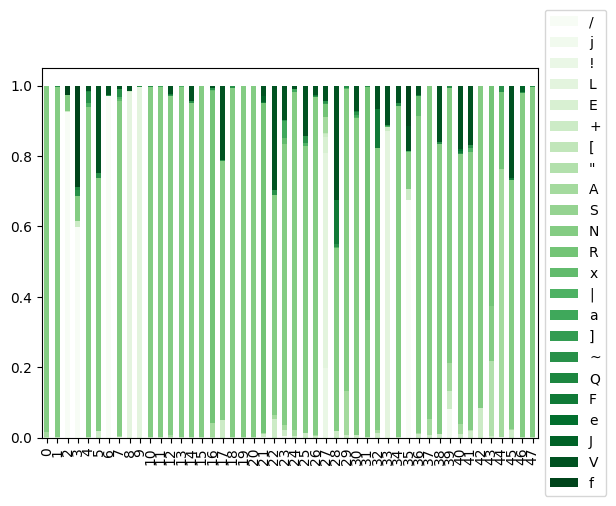

In [251]:
fig = plt.figure(figsize=(15,10))
ax = df.plot.bar(stacked = True, cmap = 'Greens')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


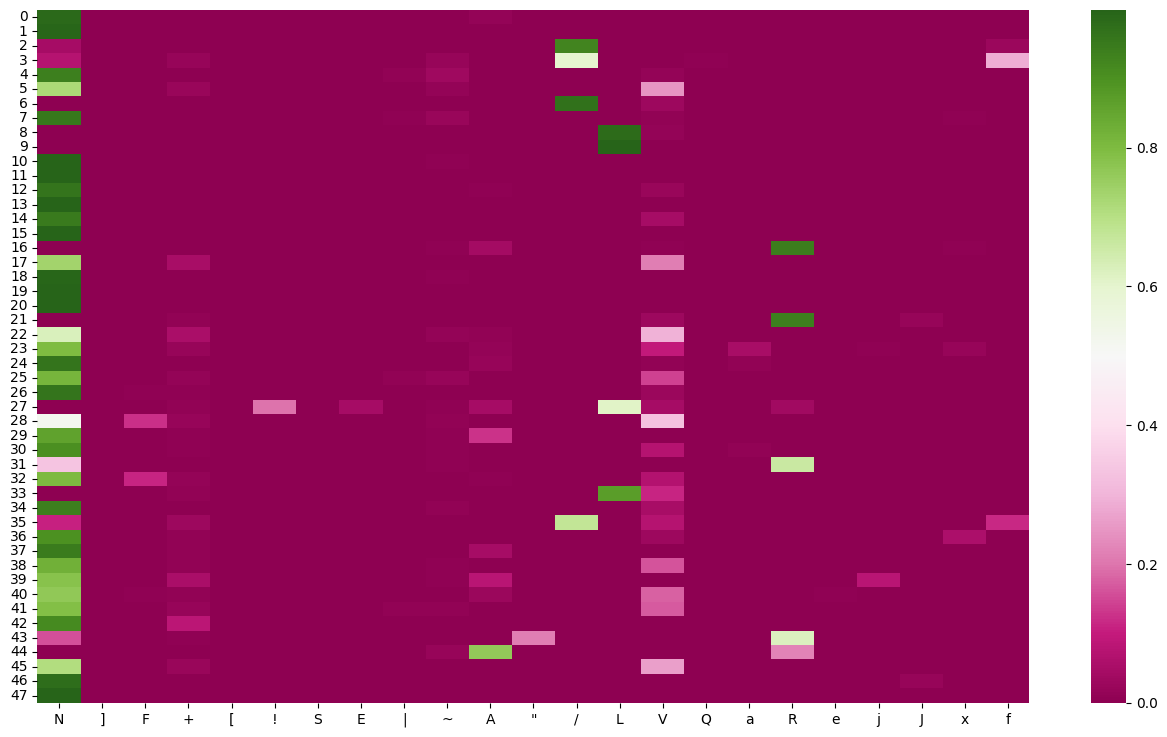

In [285]:
df = pd.DataFrame.from_dict(test_dict)
fig, ax = plt.subplots(1,1,figsize = (16,9))
ax = sns.heatmap(df,linewidth=0., cmap ="PiYG")

In [102]:
symbols = {'!',  '"',  '+',  '/',  'A',  'E',  'F',  'J',  'L',  'N',  'Q',  'R',  'S',  'V',  '[',  ']',  'a',  'e',  'f',  'j',  'x',  '|',  '~'}
beat_type_dict ={ patient: {} for patient in range(len(an))}
for p in range(len(an)):

  beat_sym = an[p].get('symbol')
  set_ = set(beat_sym)
  total_beats = len(beat_sym)
  list_set = list(set_)
  beat_type_dict[p] = {s_: None for s_ in list_set}

  for i in range(len(set_)):

    symbol = list_set[i]
    count_ = beat_sym.count(symbol)

    beat_type_dict[p][symbol] = count_/total_beats *100
    


In [ ]:
rpeaks_dict, fpfn_R_an_dict, fpfn_R_R_dict = rpeaks_extr(pat, an, 5, 12)
avg_dict = avg_fpfn(fpfn_R_an_dict)

In [21]:
heal, nonheal = healthy_not(an,0.96)
print(heal)

[0, 1, 10, 11, 12, 13, 15, 18, 19, 20, 24, 26, 46, 47]


In [25]:
healthy = [rpeaks_dict[i][0] for i in heal]
unhealthy = [rpeaks_dict[i][0] for i in nonheal]

In [88]:
for i in range(len(unhealthy)):
  timedomain(unhealthy[i])

Time domain metrics - for given NN-intervals:
- Mean NN (ms): 825.29
- STD NN/SDNN (ms): 39.35
- Mean HR (beats/min): 72.93
- STD HR (beats/min): 5.73
- Min HR (beats/min): 63.53
- Max HR (beats/min): 284.21
- RMSSD (ms): 53.51
- SDNN: 39.36
Time domain metrics - for given NN-intervals:
- Mean NN (ms): 797.95
- STD NN/SDNN (ms): 162.89
- Mean HR (beats/min): 79.02
- STD HR (beats/min): 30.83
- Min HR (beats/min): 9.18
- Max HR (beats/min): 392.73
- RMSSD (ms): 185.44
- SDNN: 162.93
Time domain metrics - for given NN-intervals:
- Mean NN (ms): 686.86
- STD NN/SDNN (ms): 102.62
- Mean HR (beats/min): 91.02
- STD HR (beats/min): 27.65
- Min HR (beats/min): 42.11
- Max HR (beats/min): 392.73
- RMSSD (ms): 124.63
- SDNN: 102.63
Time domain metrics - for given NN-intervals:
- Mean NN (ms): 890.31
- STD NN/SDNN (ms): 245.58
- Mean HR (beats/min): 73.87
- STD HR (beats/min): 24.60
- Min HR (beats/min): 33.03
- Max HR (beats/min): 295.89
- RMSSD (ms): 400.23
- SDNN: 245.64
Time domain metrics -

In [61]:
def split_healthy_not(an, percentage, sampling_rate = 360):

  heal, nonheal = healthy_not(an,percentage)
  healthy = [rpeaks_dict[i][0] for i in heal]
  unhealthy = [rpeaks_dict[i][0] for i in nonheal]

  healthy_dict = {'hr':[], 'sdnn':[], 'rmssd' : []} 
  period = 1/sampling_rate
  for i in range(len(healthy)):
    peaks = healthy[i]
    Rrss = [peaks[i]*period*1000 for i in range(len(peaks))]
    healthy_dict['hr'].append(calculate_heart_rate(peaks,sampling_rate))
    healthy_dict['sdnn'].append(sdnn_measure(Rrss))
    healthy_dict['rmssd'].append(rmssd_measure(Rrss))


  unhealthy_dict = {'hr':[], 'sdnn':[], 'rmssd' : []} 
  period = 1/sampling_rate
  for i in range(len(unhealthy)):
    peaks = unhealthy[i]
    Rrss = [peaks[i]*period*1000 for i in range(len(peaks))]
    unhealthy_dict['hr'].append(calculate_heart_rate(peaks,sampling_rate))
    unhealthy_dict['sdnn'].append(sdnn_measure(Rrss))
    unhealthy_dict['rmssd'].append(rmssd_measure(Rrss))


  return healthy_dict, unhealthy_dict


In [63]:
h, n  = split_healthy_not(an,0.96)

In [65]:
h_sdnn = h['sdnn']
n_sdnn = n['sdnn']

Text(0, 0.5, 'SDNN')

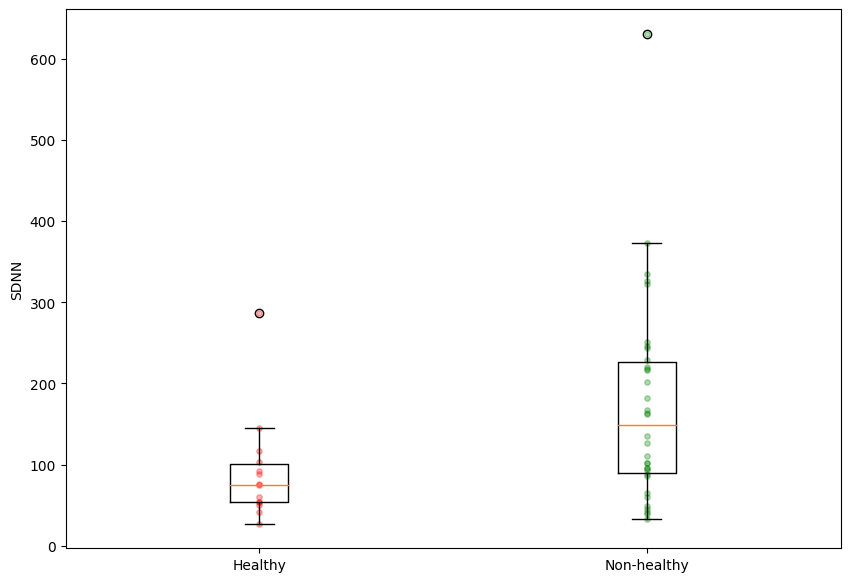

In [92]:
fig, axs = plt.subplots(1, 1, figsize = (10,7))
axs.boxplot([h_sdnn,n_sdnn],labels=['Healthy', 'Non-healthy'])

x = [1 for i in range(len(h_sdnn))]
plt.scatter(x, h_sdnn, s =15 , color = 'r' , alpha=0.3)

x2 = [2 for i in range(len(n_sdnn))]
plt.scatter(x2, n_sdnn, s =15 , color = 'green' , alpha=0.3 )

plt.ylabel('SDNN')

In [93]:
h_rmssd = h['rmssd']
n_rmssd = n['rmssd']

Text(0, 0.5, 'RMSSD')

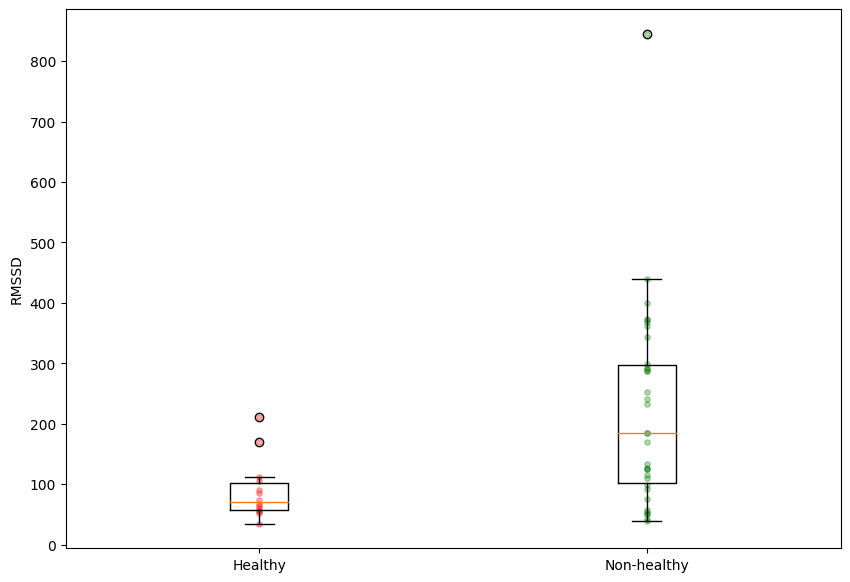

In [94]:
fig, axs = plt.subplots(1, 1, figsize = (10,7))
axs.boxplot([h_rmssd,n_rmssd],labels=['Healthy', 'Non-healthy'])

x = [1 for i in range(len(h_rmssd))]
plt.scatter(x, h_rmssd, s =15 , color = 'r' , alpha=0.3)

x2 = [2 for i in range(len(n_rmssd))]
plt.scatter(x2, n_rmssd, s =15 , color = 'green' , alpha=0.3 )

plt.ylabel('RMSSD')

In [ ]:
def split_fr(an, percentage, sampling_rate = 360):

  heal, nonheal = healthy_not(an,percentage)
  healthy = [rpeaks_dict[i][0] for i in heal]
  unhealthy = [rpeaks_dict[i][0] for i in nonheal]

  healthy_dict = {'hr':[], 'sdnn':[], 'rmssd' : []} 
  period = 1/sampling_rate
  for i in range(len(healthy)):
    peaks = healthy[i]
    Rrss = [peaks[i]*period*1000 for i in range(len(peaks))]
    healthy_dict['hr'].append(calculate_heart_rate(peaks,sampling_rate))
    healthy_dict['sdnn'].append(sdnn_measure(Rrss))
    healthy_dict['rmssd'].append(rmssd_measure(Rrss))


  unhealthy_dict = {'hr':[], 'sdnn':[], 'rmssd' : []} 
  period = 1/sampling_rate
  for i in range(len(unhealthy)):
    peaks = unhealthy[i]
    Rrss = [peaks[i]*period*1000 for i in range(len(peaks))]
    unhealthy_dict['hr'].append(calculate_heart_rate(peaks,sampling_rate))
    unhealthy_dict['sdnn'].append(sdnn_measure(Rrss))
    unhealthy_dict['rmssd'].append(rmssd_measure(Rrss))


  return healthy_dict, unhealthy_dict


In [ ]:
x = [pat[i].get('record_name') for i in range(len(pat))]

In [ ]:
paper = [2273, 1865, 2187, 2230, 2572, 2027, 2137, 1763, 2532, 2124, 2539, 1795, 1879, 1953, 2412, 1535, 2275, 1987, 1863, 2476, 1518, 1619, 2601, 1963, 2136, 2982, 2656, 1862, 2956, 3004,
2647, 2748, 3251, 2262, 3363, 2208, 2154, 2048, 2427, 2484, 2605, 2053, 2256, 1886, 1780, 3079, 2753, 2084]

In [ ]:
method = [len(rpeaks_dict[i]) for i in range(len(rpeaks_dict))]

In [ ]:
fig = plt.figure(figsize = (10,7))

plt.scatter(x , paper, color = 'purple', label = 'total number from paper')
plt.scatter(x, method, color = 'purple', alpha = 0.5, label = 'total number from method')
plt.grid('on')
plt.xticks(rotation=45)
plt.legend()
plt.title('Total number of detected R-peaks')
plt.ylabel('number of R-peaks')
plt.xlabel('Record number of subject')

In [ ]:
avg_dict = avg_fpfn(fpfn_R_an_dict)


data = [avg_dict['tp'] , avg_dict['fp'], avg_dict['fn']]
import seaborn as sns 

fig = plt.figure(figsize =(10, 7))
x_ax = ['TP', 'FP', 'FN']
ax = sns.boxplot(data , palette = 'husl')
ticks = [0,1,2]

ax.set_xticklabels(x_ax)
ax.set_title('The TP, FP, FN among R-peaks from code implementation and annotations')


In [ ]:
peaks_1 = find_peaks(ecg_filt_1, distance=200)[0]
peaks_2 = find_peaks(ecg_filt_2, distance=200)[0]

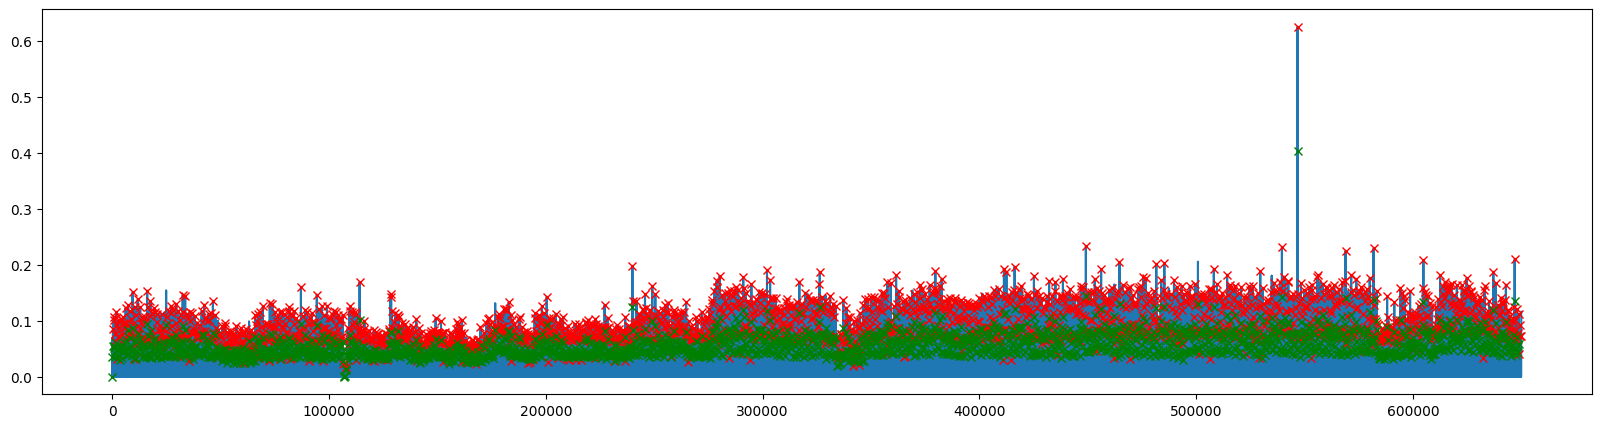

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(ecg_filt)
plt.plot(r_peaks, ecg_filt[r_peaks], "xr")

plt.plot(sb[:-5], ecg_filt[sb[:-5]], 'xg')

In [ ]:
from scipy.signal import argrelextrema

peaks = find_peaks(ecg_normalized, distance=180)[0]

plt.plot(peaks, ecg_normalized[peaks], "xr")
plt.plot(ecg_normalized)

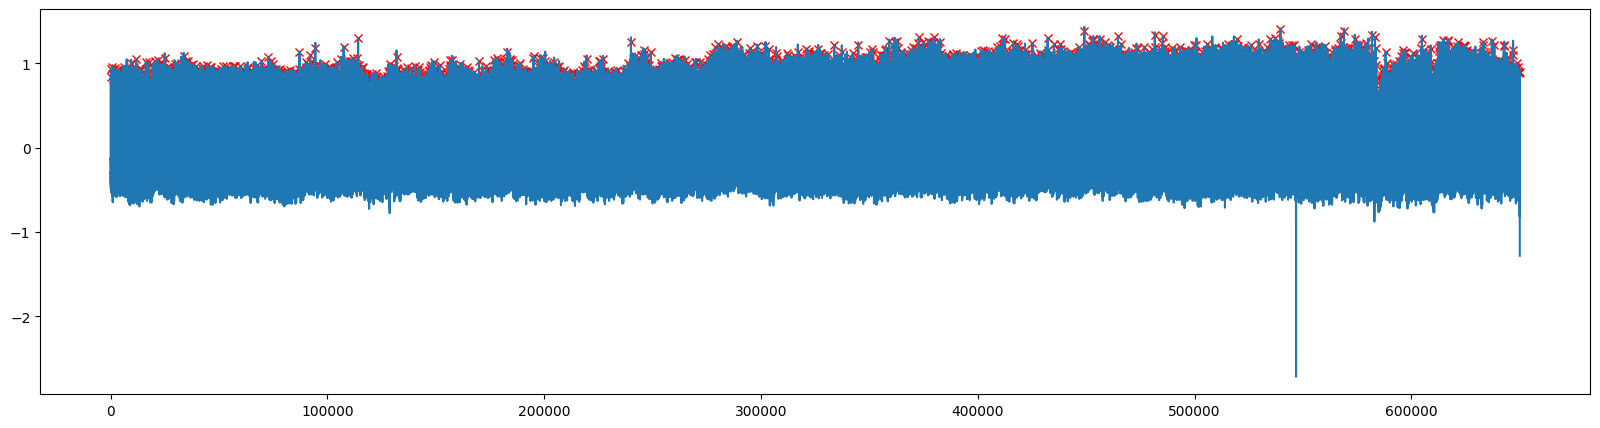

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(peaks, ecg[peaks], "xr")
plt.plot(ecg)

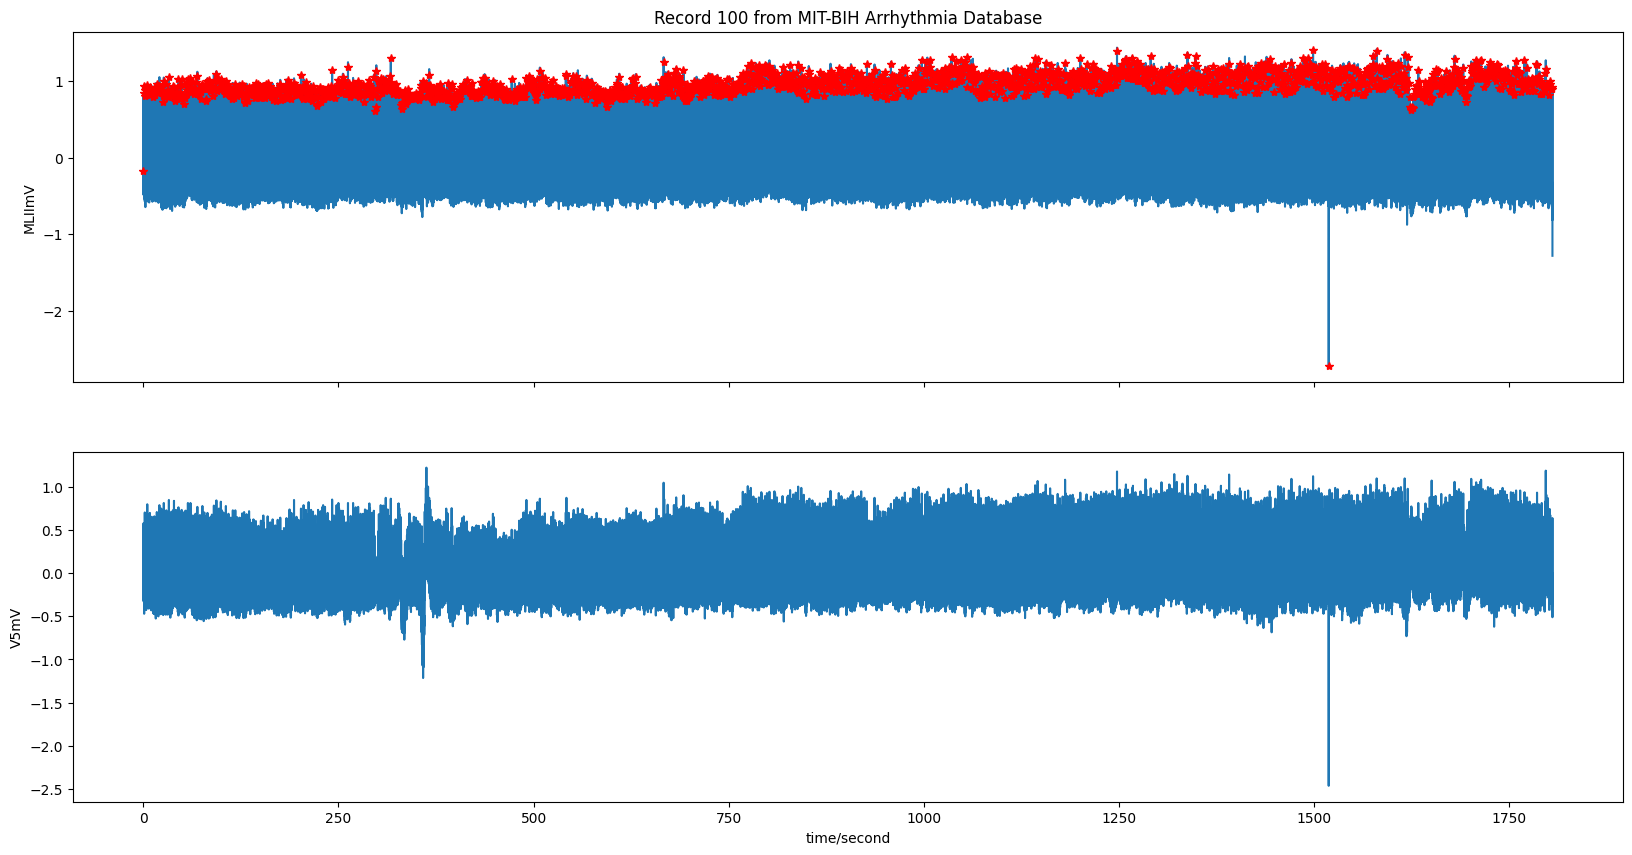

In [ ]:
annotation = wfdb.rdann(str(data_path / "100"), extension="atr")
 
wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 100 from MIT-BIH Arrhythmia Database',
               time_units='seconds', figsize=(20, 10))
# # dir(record)

TIME - DOMAIN MEASURE FUNCTIONS and TESTS

In [ ]:
period = 1/360
rrs = rpeaks_dict[0][0]
len(rrs)
rrss = [rrs[i]*period*1000 for i in range(len(rrs))]
nn_intervals = np.diff(rrss)
hr = 60000/nn_intervals
print(np.mean(hr))

75.84002054010699


In [33]:
def timedomain(peaks):

    # CHANGED
    period = 1/360
    Rrss = [peaks[i]*period*1000 for i in range(len(peaks))]
    rr = nn_intervals(Rrss)
    hr = calculate_heart_rate(peaks)
    
    results = {}
    results['Mean NN (ms)'] = np.mean(rr)
    results['STD NN/SDNN (ms)'] = np.std(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = rmssd_measure(Rrss)
    results['SDNN'] = sdnn_measure(Rrss)
    # results['SDANN'] = sdann_measure(Rrss)
    # results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    # results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)

    print("Time domain metrics - for given NN-intervals:")
    for k, v in results.items():
      print("- %s: %.2f" % (k, v))

    return 

In [34]:
def nn_intervals(peaks):

  peak_s = [peaks[i] for i in range(len(peaks))]

  p_size = len(peak_s)
  nn_inter = np.zeros(p_size-1)

  for i in range(p_size-1):
    nn_inter[i] = peak_s[i+1] - peak_s[i]

  return nn_inter

In [ ]:
nn_intervals(peaks)

array([293., 293., 284., ..., 252., 250., 258.])

In [52]:
def sdnn_measure(peaks):

  nn_inter = nn_intervals(peaks)

  sdnn = np.std(nn_inter, ddof=1)

  return sdnn

In [ ]:
sdnn_measure(peaks)

18.022635163653078

In [346]:
def peaks_per_inter(peaks, time_range = 300):
  
  """
  time_range : Time range to split in seconds (Default: 300[s] = 5[mins])

  """

  nn_inter = nn_intervals(peaks).tolist()

  tot_duration = np.sum(nn_inter)

  number_of_splits = int(np.ceil(tot_duration / time_range))
  
  split_dict = {str(i)+'_inter':[] for i in range(number_of_splits)}

  peak_int = [int(peak_/time_range) for peak_ in peaks]

  for i in range(number_of_splits):

    k = peak_int[i]

    split_dict[str(k)+'_inter'].append(nn_inter[i])

    

  return split_di


In [347]:
def sdann_measure(peaks, time_range = 300):


  nn_inter = nn_intervals(peaks)

  split_dict = peaks_per_inter(peaks)
  
  keys_ = list(split_dict.keys())

  avg_split_dict = {key:[] for key in keys_}

  for key in keys_:
      
      avg_split_dict[key] = max(0, np.mean(peaks_per_inter(peaks)[key]) )

  avg_list = list(avg_split_dict.values())
  # flat_avg_list =  [num for sublist in avg_list for num in sublist]

  sdann = np.std(avg_list, ddof=1)

  return sdann

In [55]:
def rmssd_measure(peaks):

  nn_inter = nn_intervals(peaks)
  nn_dif = [nn_inter[i+1] - nn_inter[i] for i in range(len(nn_inter)-1)]
  
  rmssd = np.sum([x_**2 for x_ in nn_dif])
  rmssd = np.sqrt(rmssd / len(nn_dif))

  return rmssd

In [ ]:
rmssd_measure(peaks)

21.864045451756716

In [355]:
timedomain(r_peaks)

Time domain metrics - for given NN-intervals:
- Mean NN (ms): 794.61
- STD NN/SDNN (ms): 53.39
- Mean HR (beats/min): 75.87
- STD HR (beats/min): 5.50
- Min HR (beats/min): 53.20
- Max HR (beats/min): 114.89
- RMSSD (ms): 73.55
- SDNN: 53.40


FREQUENCY - DOMAIN MEASURE FUNCTIONS and TESTS

In [338]:
from scipy.interpolate import interp1d 

period = 1/360
Rrss = [r_peaks[i]*period*1000 for i in range(len(r_peaks))]
rr_manual = nn_intervals(Rrss)

# rr_manual = nn_intervals(peaks)
x = np.cumsum(rr_manual) / 1000
f = interp1d(x, rr_manual, kind='cubic')

In [339]:
# sample rate for interpolation
fs = 4
steps = 1 / fs

# now we can sample from interpolation function
xx = np.arange(1, np.max(x), steps)
rr_interpolated = f(xx)

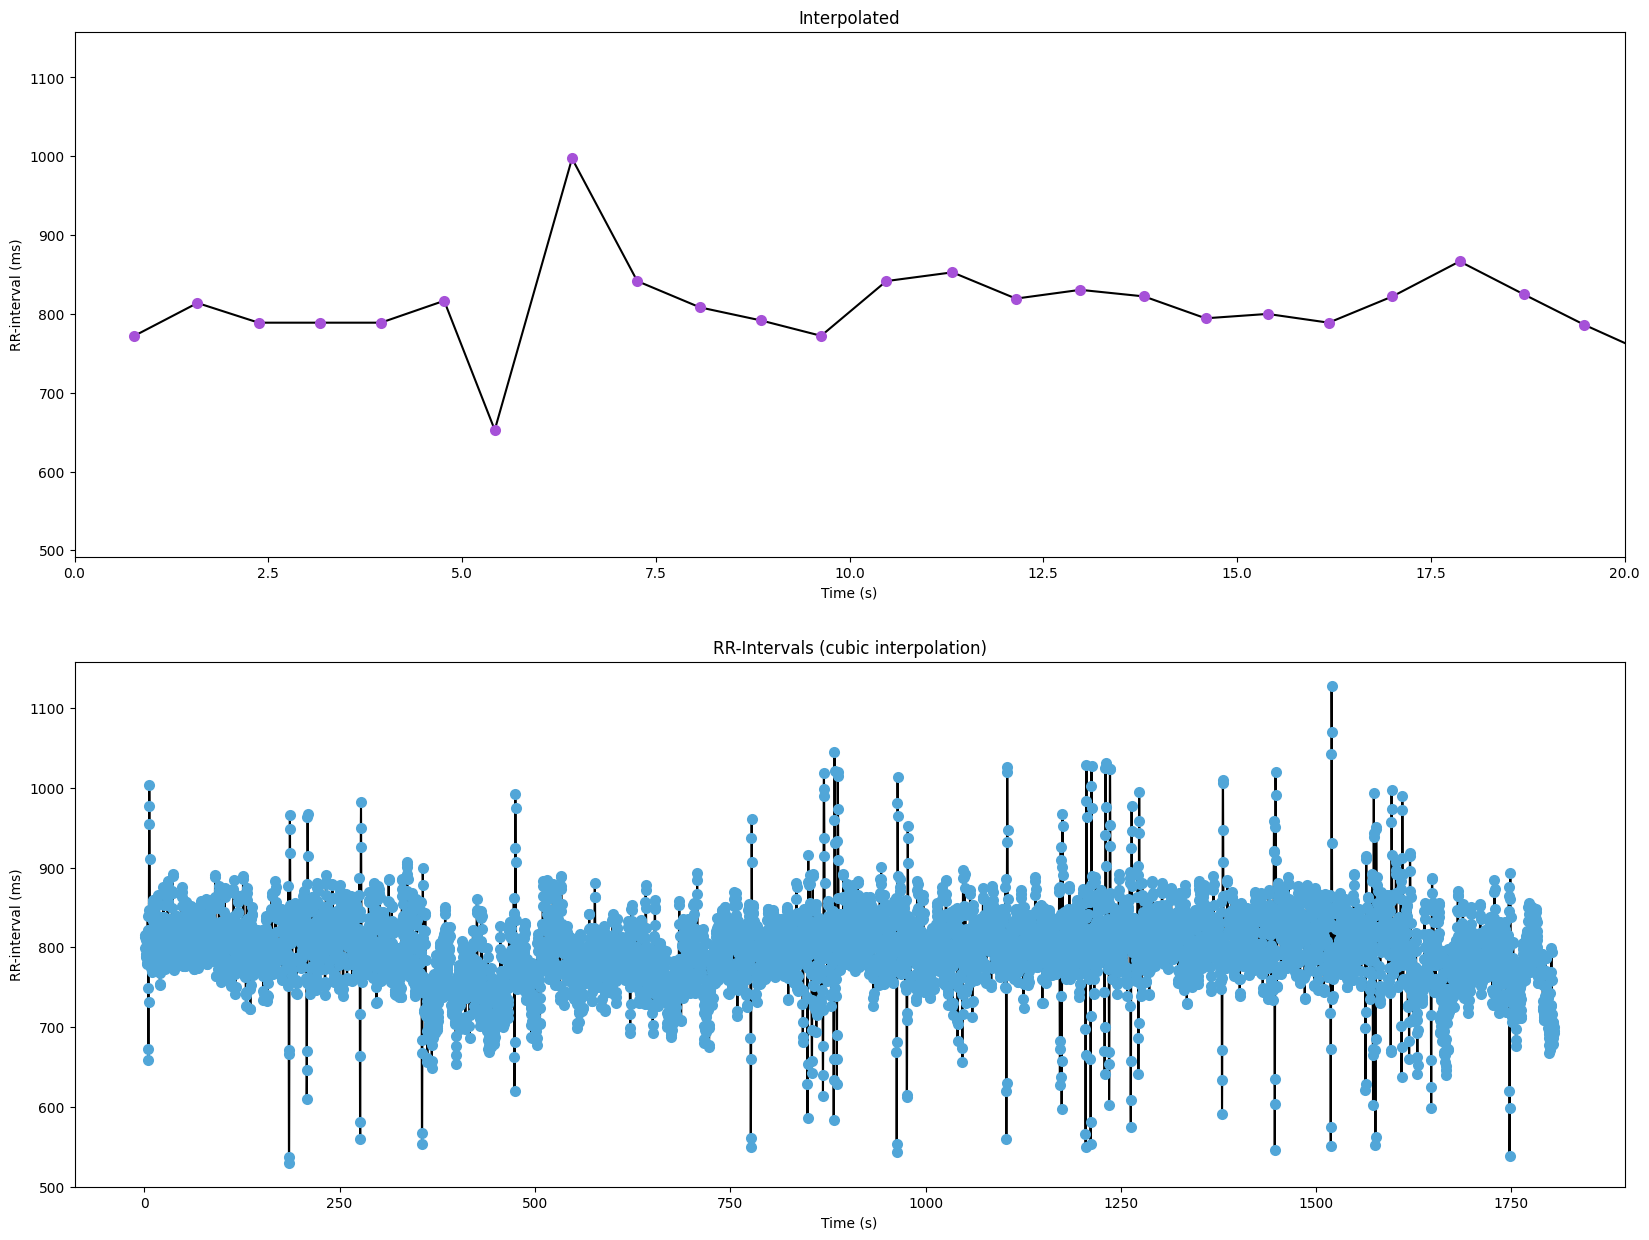

In [340]:
plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(x, rr_manual, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 20)

plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
plt.plot(xx, rr_interpolated, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
# plt.gca().set_xlim(0, 20)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

In [341]:
from scipy.integrate import trapz

def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
        # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [342]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(rr_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 153.27
- Power LF (ms2): 71.20
- Power HF (ms2): 922.55
- Power Total (ms2): 1147.02
- LF/HF: 0.08
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.05
- Peak HF (Hz): 0.17
- Fraction LF (nu): 7.16
- Fraction HF (nu): 92.84


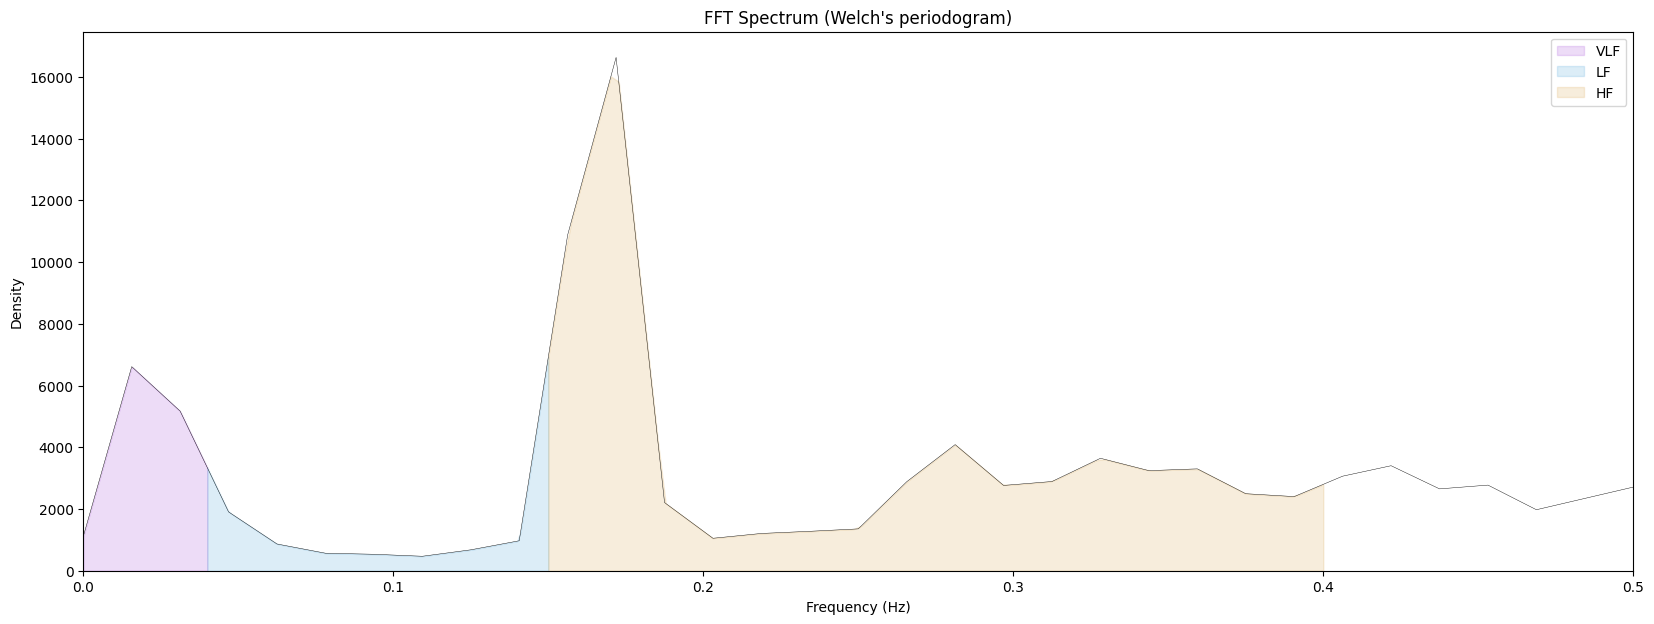

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(fxx, pxx, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
data_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/ecg_data/physionet.org/files/mitdb/1.0.0")

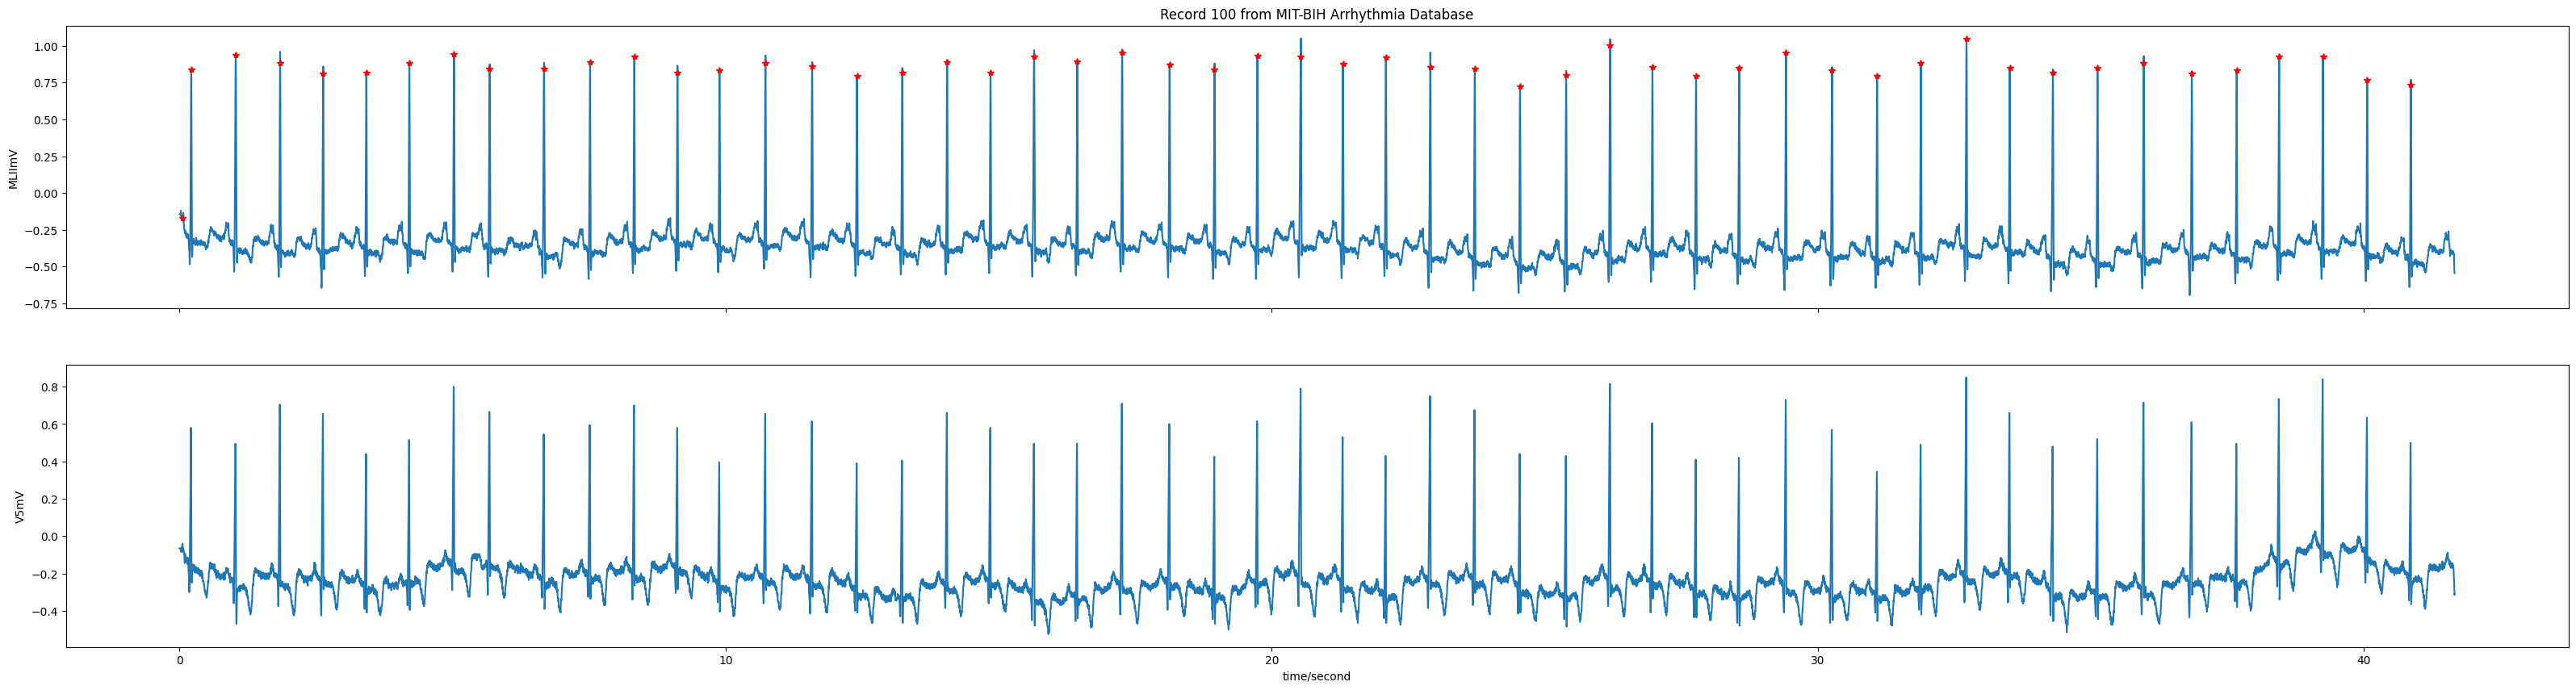

In [ ]:
record = wfdb.rdrecord(data_path / "100" , sampto = 15000)
annotation = wfdb.rdann(str(data_path / "100"), extension="atr", sampto = 15000)
 
wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 100 from MIT-BIH Arrhythmia Database',
               time_units='seconds', figsize=(40,10))


In [ ]:
dat = np.fromfile(data_path / "100.dat")
atr = np.fromfile(data_path / "100.atr")
hea = np.fromfile(data_path / "100.hea")
xws = np.fromfile(data_path / "100.xws")

In [ ]:
dat.shape, atr.shape, hea.shape, xws.shape

((243750,), (569,), (17,), (11,))

In [ ]:
with open(
    os.path.join(data_path, '100.hea'),
    "r",
    encoding="ascii",
    errors="ignore",
) as f:
    header_content1 = f.read()

In [ ]:
print(str(header_content1))

100 2 360 650000
100.dat 212 200 11 1024 995 -22131 0 MLII
100.dat 212 200 11 1024 1011 20052 0 V5
# 69 M 1085 1629 x1
# Aldomet, Inderal



In [ ]:
record = wfdb.rdsamp('mitdb/100')
annotation = wfdb.rdann('mitdb/100', 'atr')

In [ ]:
record[0].shape

(650000, 2)

In [ ]:
wfdb.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed QRS detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


In [ ]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [ ]:
head = wfdb.rdrecord('100', pn_dir='mitdb')

In [ ]:
# if os.path.isdir("mitdb"):
#     print('You already have the data.')
# else:
#     wfdb.dl_database('mitdb', 'mitdb')

In [ ]:
# # annotation = wfdb.rdann(str(data_path / "100"), extension="dat", sampto = 5000)
 
# wfdb.plot_wfdb(record=record, 
#                title='Record 100 from MIT-BIH Arrhythmia Database',
#                time_units='seconds', figsize=(20, 10))
# # dir(record)
# # plt.figure(figsize=(20,10))
# # plt.plot(record.p_signal[:, 1])
# # dir(annotation), annotation.sample

# fig, axs = plt.subplots(2, 1, figsize=(20, 10))
# axs[0].plot(record.p_signal[:, 0])
# axs[1].plot(record.p_signal[:, 1])

In [ ]:
record = wfdb.rdrecord(data_path / '100')
display(record.__dict__)

{'record_name': '100',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'sig_name': ['MLII', 'V5'],
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [995, 1011],
 'checksum': [-22131, 20052],
 'block_size': [0, 0]}

In [ ]:

# Load ECG data
ecg = record.p_signal[:,0]

# Define filter parameters
fs = record.fs  # Sampling frequency
f_low = 5  # Low cutoff frequency
f_high = 15  # High cutoff frequency
order = 4 # Filter order

# Create bandpass filter
b, a = signal.butter(order, [f_low / (fs/2), f_high / (fs/2)], btype='bandpass')

# Apply filter to ECG signal
ecg_filtered = signal.filtfilt(b, a, ecg)

# Perform baseline correction
ecg_corrected = ecg_filtered - np.mean(ecg_filtered)

# Normalize signal
ecg_normalized = ecg_corrected / np.max(np.abs(ecg_corrected))


In [ ]:
ecg_signal = record.p_signal[:,0]
fs = record.fs
rps = detect_r_peaks(ecg_signal, fs)

In [226]:
symbols = {'!',  '"',  '+',  '/',  'A',  'E',  'F',  'J',  'L',  'N',  'Q',  'R',  'S',  'V',  '[',  ']',  'a',  'e',  'f',  'j',  'x',  '|',  '~'}
beat_type_dict ={ patient: {s_ : 0 for s_ in symbols} for patient in range(len(an))}

for p in range(len(an)):

  beat_sym = an[p].get('symbol')
  set_ = set(beat_sym)
  total_beats = len(beat_sym)
  list_set = list(set_)

  for i in range(len(set_)):

    symbol = list_set[i]
    count_ = beat_sym.count(symbol)

    beat_type_dict[p][symbol] = count_/total_beats 
    